#### This notebook gives the mstm-wrapper results for 1 sphere, in order to compare to mie.py for debugging

In [1]:
import mstm
import matplotlib
%matplotlib notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.integrate
from mpl_toolkits.mplot3d import Axes3D

### First, let's calculate scattered intensity as a function of theta, for a fixed phi = 0, and compare to azimuthal average
The target has 1 sphere of radius 0.125 um, and the incident is parallel polarized. The incident has $\lambda = 0.4$ $\mu$m.

<IPython.core.display.Javascript object>


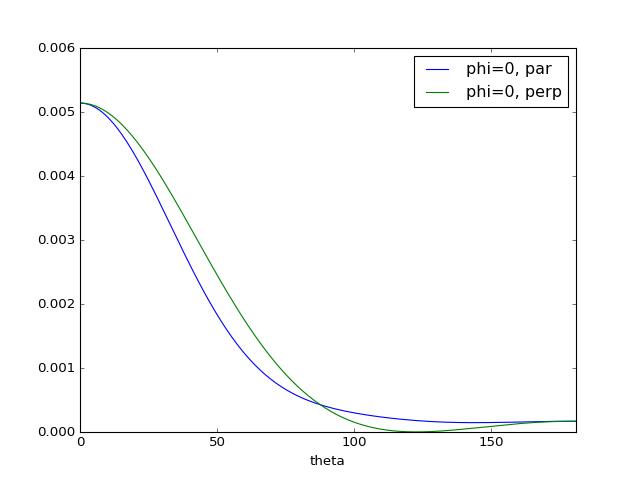

<IPython.core.display.Javascript object>


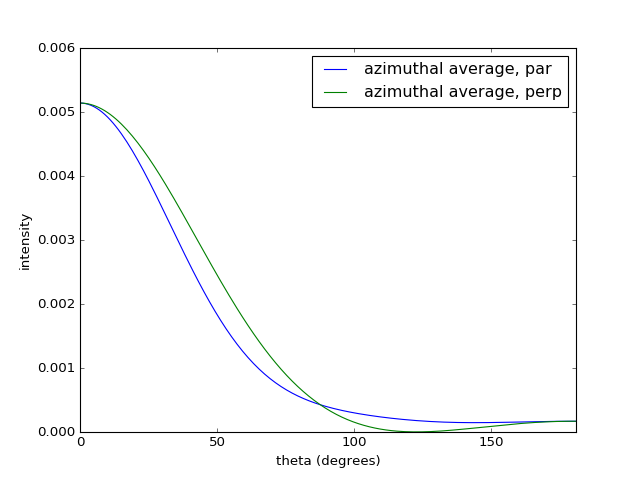

,qext,qabs,qsca
unpolarized,2.0238,0,2.0238
par,2.0238,0,2.0238
perp,2.0238,0,2.0238


In [2]:
# make target object
xpos = np.array([0])
ypos = np.array([0])
zpos = np.array([0])
radii = np.array([0.125])
n_matrix = 1.0
n_spheres = 1.54
target = mstm.Target(xpos, ypos, zpos, radii, n_matrix, n_spheres)

theta = np.linspace(0, 181, 181)
phi = np.array([0])
stokes_par = np.array([1, 1, 0, 0])
stokes_perp = np.array([1, -1, 0, 0])
wavelength = 0.4

# run MSTM and calculate the intensities
calculation = mstm.MSTMCalculation(target, wavelength, theta, phi)
result = calculation.run()
intensity_par = result.calc_intensity(stokes_par)
intensity_perp = result.calc_intensity(stokes_perp)
result.efficiencies[0]

# plot intensity versus theta
ax = intensity_par[0].plot(x='theta',y='intensity', label='phi=0, par')
intensity_perp[0].plot(x='theta', y='intensity', ax=ax, label='phi=0, perp')

# calculate azimuthal average intensity and plot
calculation = mstm.MSTMCalculation(target, wavelength, theta, phi=None)
result = calculation.run()
intensity_par = result.calc_intensity(stokes_par)
intensity_perp = result.calc_intensity(stokes_perp)

ax = intensity_par[0].plot(x='theta',y='intensity', label='azimuthal average, par')
intensity_perp[0].plot(x='theta',y='intensity', ax=ax, label='azimuthal average, perp')

plt.xlabel('theta (degrees)')
plt.ylabel('intensity')
result.efficiencies[0]


The results are in agreement with calculations from BHMIE.  However, the magnitudes are off by a constant factor.  

Note that the azimuthally averaged intensities are the same as the non-azimuthally-averaged intensities.  This is because an azimuthal average means that we rotate the scattering plane about the z-axis by an angle $\phi$ and average the scattering over $\phi$.  We do this for a particular Stokes vector that indicates the polarization.  However, that polarization is _relative to the scattering plane_ (see Bohren and Huffman p. 113).  Thus, for a sphere, the azimuthal average is the same as the non-azimuthal average, because the polarization direction rotates as the scattering plane. And that is what we see here.

### Next, let's calculate the scattered intensity as a function of theta and phi
The target has 1 sphere of radius 0.125 um, and the incident is parallel polarized. The incident has $\lambda = 0.4$ $\mu$m.

<IPython.core.display.Javascript object>


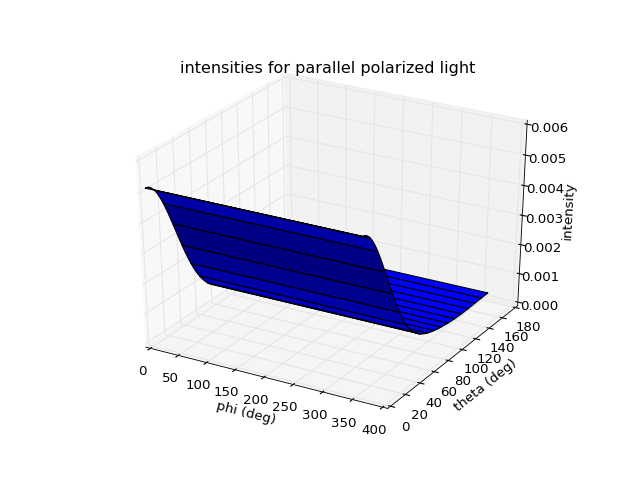

In [3]:
theta = np.linspace(0, 180, 181)
phi = np.linspace(0, 360, 10)
stokes_vec = np.array([1, 1, 0, 0])

# calculate the intensities
calculation = mstm.MSTMCalculation(target, wavelength, theta, phi)
result = calculation.run()
intensity = result.calc_intensity(stokes_vec)

# reshape the result to be a 2d array
table = intensity[0].pivot_table('intensity', 'theta', 'phi')

plt.figure()
ax = plt.axes(projection = '3d')
p,t=np.meshgrid(phi,theta)
ax.plot_surface(p,t,table.as_matrix())
ax.set_zlabel('intensity')
plt.xlabel('phi (deg)')
plt.ylabel('theta (deg)')
plt.title('intensities for parallel polarized light')

### Now we calculate the intensity as a function of theta and phi, but for perpendicularly polarized incident light
The target has 1 sphere of radius 0.125 um, and the incident is perpendicularly polarized. The incident has $\lambda = 0.4$ $\mu$m.

<IPython.core.display.Javascript object>


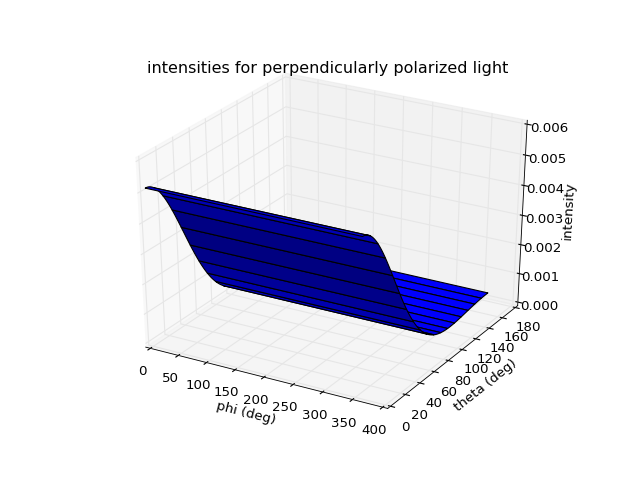

In [4]:
theta = np.linspace(0, 180, 181)
phi = np.linspace(0, 360, 10)
stokes_vec = np.array([1, -1, 0, 0])

# calculate the intensities
calculation = mstm.MSTMCalculation(target, wavelength, theta, phi)
result = calculation.run()
intensity = result.calc_intensity(stokes_vec)

# reshape the result to be a 2d array
table = intensity[0].pivot_table('intensity', 'theta', 'phi')

plt.figure()
ax = plt.axes(projection = '3d')
p,t=np.meshgrid(phi,theta)
ax.plot_surface(p,t,table.as_matrix())
ax.set_zlabel('intensity')
plt.xlabel('phi (deg)')
plt.ylabel('theta (deg)')
plt.title('intensities for perpendicularly polarized light')

Again, there is no $\phi$ dependence because the Stokes vector is defined with respect to the scattering plane.  Therefore the direction of polarization rotates as $\phi$ changes.  If we choose a Stokes vector of $\left[1, -1, 0, 0\right]$, indicating vertically polarized light, the polarization direction is always perpendicular to the scattering plane.

### Now let's look at the integrated Intensities as a function of wavelength

<IPython.core.display.Javascript object>


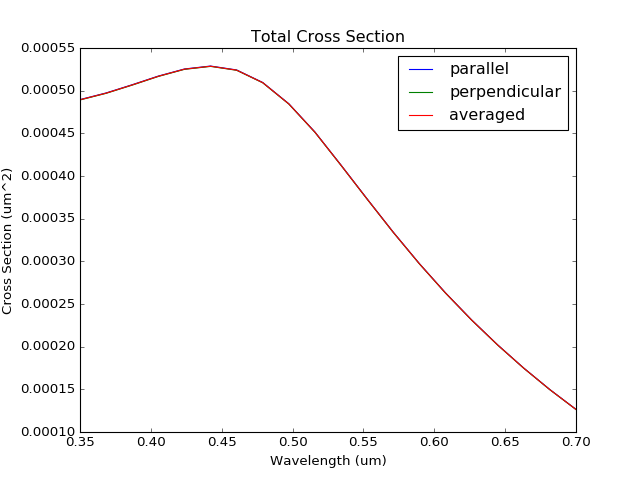

In [6]:
wavelength = 0.35, 0.7, 20
theta = np.linspace(0, 180, 181)

# calculate the cross section for horizontal polarization
calculation = mstm.MSTMCalculation(target, wavelength, theta, phi=None)
result = calculation.run()
total_csca_perp = result.calc_cross_section(np.array([1, 1, 0, 0]), 0., 180.)

# calculate the cross section for horizontal polarization
total_csca_par = result.calc_cross_section(np.array([1, -1, 0, 0]), 0., 180.)

plt.figure()
plt.plot(result.wavelength, total_csca_par)
plt.plot(result.wavelength, total_csca_perp)
plt.plot(result.wavelength, (total_csca_par+total_csca_perp)/2)
plt.legend(['parallel','perpendicular','averaged'])
plt.xlabel('Wavelength (um)')
plt.xlim([0.35,0.7])
plt.ylabel('Cross Section (um^2)')
plt.title('Total Cross Section')

The results look similar to results from BHMIE, but the curve doesn't have the correct shape.  I suspect this problem is related to the problem of why the intensity magnitudes are incorrect.  We are probably omitting a factor of $k$ somewhere, which would correct the wavelength-dependence.